## AIM: Train a multiclass classification model for predicting the psychiatric diagnosis based on EEG features

We will start with training a Support Vector Classification model to predict psychiatric diagnosis with the variance in power per frequency band per channel group (frontal, central, parietal, occipital).

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import mne
import os
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_multitaper

%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

### Loading in feature data

In [2]:
df_features = pd.read_pickle('D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features/df_std_features.pkl')
df_features['age'] = df_features['age'].round().astype('Int32') # round age to nearest year and convert to int
df_features.sample(7)

,ID,age,gender,diagnosis,epoch,EO_frontal_delta,EO_central_delta,EO_parietal_delta,EO_occipital_delta,EO_frontal_theta,...,EC_parietal_alpha,EC_occipital_alpha,EC_frontal_beta,EC_central_beta,EC_parietal_beta,EC_occipital_beta,EC_frontal_gamma,EC_central_gamma,EC_parietal_gamma,EC_occipital_gamma
922,sub-87970301,59,0.0,SMC,11,0.418302,0.350318,0.373291,0.358931,0.312307,...,0.360868,0.301141,0.292436,0.288326,0.287530,0.275733,0.261164,0.264182,0.262324,0.266798
13060,sub-88074377,52,0.0,TBI,8,0.385312,0.399045,0.356036,0.385653,0.295009,...,0.392141,0.456499,0.270068,0.280594,0.281573,0.283108,0.272956,0.271368,0.280815,0.294397
10420,sub-88054849,<NA>,1.0,NaN,8,0.417035,0.403227,0.421483,0.534261,0.338044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3844,sub-88013717,20,0.0,NaN,5,0.333118,0.317163,0.313607,0.321409,0.302893,...,0.364175,0.369782,0.340838,0.330604,0.330660,0.329500,0.273698,0.272344,0.274570,0.274667
10349,sub-88054357,61,0.0,MDD,9,0.400948,0.348169,0.341153,0.374071,0.343209,...,0.367526,0.330444,0.290601,0.289278,0.307802,0.311783,0.254274,0.240444,0.239667,0.236256
6530,sub-88027217,61,1.0,BIPOLAR,6,0.329941,0.348683,0.372318,0.388246,0.259494,...,0.297054,0.271491,0.287640,0.296975,0.291309,0.270535,0.319685,0.299003,0.268389,0.250259
2745,sub-88008949,32,1.0,NaN,10,0.393621,0.388213,0.403912,0.393343,0.401122,...,0.368680,0.379494,0.293733,0.283656,0.295684,0.307081,0.300054,0.300791,0.314545,0.318077


In [3]:
# select top 5 diagnoses for now
top_5 = df_features['diagnosis'].value_counts()[:5].index.tolist()
df_features = df_features[df_features['diagnosis'].isin(top_5)]
df_features['diagnosis'] = df_features['diagnosis'].astype('category')
df_features['diagnosis'].value_counts()


diagnosis
MDD        3732
ADHD       2051
SMC        1032
HEALTHY     564
OCD         540
Name: count, dtype: int64

In [4]:
# label encode diagnosis (alphabatic order by default) # misschien beter via labelbinarizer()?
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_features['diagnosis'] = le.fit_transform(df_features['diagnosis'])
print(df_features['diagnosis'].value_counts())
df_features['diagnosis'] = df_features['diagnosis'].astype('category')
print(df_features['diagnosis'].dtype)

diagnosis
2    3732
0    2051
4    1032
1     564
3     540
Name: count, dtype: int64
category


In [5]:
# channel groupings
frontal = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4']
central = ['T7', 'C3', 'Cz', 'C4', 'T8']
parietal = ['CP3','CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8'] 
occipital = ['O1', 'Oz', 'O2']
channel_groups = {'frontal': frontal, 'central': central, 'parietal': parietal, 'occipital': occipital}

# define (5) frequencies of interest for TFR per frequency band
delta = np.array([1, 1.5, 2, 2.5, 3]) # starting at one because of high-pass filter
theta = np.array([4, 4.75, 5.5, 6.25, 7])
alpha = np.array([8, 9, 10, 11, 12])
beta = np.array([13, 17.25, 21.5, 25.75, 30])
gamma = np.array([42, 54, 66, 78, 90]) 
bands = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma}

### Training the model (SVC)

In [59]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC


# assign groups (IDs) for GroupKFold
groups = df_features['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = ['age']
for cond in ['EO', 'EC']:
    for band in bands:
        for group in channel_groups:
            numeric_cols.append(f'{cond}_{group}_{band}')
cat_cols = ['gender']
 
X = df_features[numeric_cols + cat_cols]
Y = df_features['diagnosis']

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')) # median imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# hyperparameter ranges for GridSearch
param_grid = {
'rbf_svm__C': [0.01, 0.1, 1, 10, 100],
'rbf_svm__gamma': [0.1, 1, 10, 100],
'rbf_svm__kernel': ['rbf'],
}

# final pipeline
steps = [('col_trans', col_trans), ('rbf_svm', SVC(class_weight = 'balanced'))]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

# define gridsearch
gridsearch = GridSearchCV(pipeline,
                        param_grid = param_grid,
                        cv = cv_inner, # use inner cv for hyperparameter tuning
                        scoring = f1_scorer,
                        error_score = 'raise',
                        return_train_score = True,
                        n_jobs=4,
                        verbose=2)

# non-nested CV for obtaining the propable best hyperparameters
gridsearch_fit = gridsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {gridsearch_fit.best_params_}')
print(f'Best f1-score: {gridsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
svm_test_score = cross_val_score(gridsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=2,
                                 n_jobs=4)
print('SVM test scores:', svm_test_score)
print('Mean SVM test score:', np.mean(svm_test_score))


# of instances: 7919
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'rbf_svm__C': 1, 'rbf_svm__gamma': 0.1, 'rbf_svm__kernel': 'rbf'}
Best f1-score: 0.5131823225835875


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM test scores: [0.51143089 0.51429433 0.52320234 0.52762756 0.53118789]
Mean SVM test score: 0.5215486003746894


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  7.3min finished


f1_score: 0.5217804753348769

classification report:
               precision    recall  f1-score   support

        ADHD       0.53      0.65      0.59      2051
     HEALTHY       0.19      0.15      0.17       564
         MDD       0.62      0.58      0.59      3732
         OCD       0.19      0.13      0.16       540
         SMC       0.50      0.53      0.52      1032

    accuracy                           0.53      7919
   macro avg       0.41      0.41      0.40      7919
weighted avg       0.52      0.53      0.52      7919



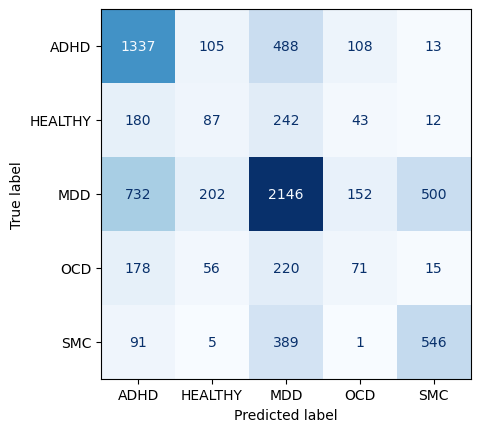

In [60]:
# final pipeline
steps = [('col_trans', col_trans), ('rbf_svm', svm.SVC(kernel = 'rbf', C = 1, gamma = 0.1, class_weight = 'balanced'))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=4)    
class_labels = sorted(top_5)
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted'))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)


Checking the importance of 'age' as feature. I expect that currently the age has too much of an influence on the prediction (leading to overfitting), due to the 12 epochs per participant and the specificity of 'age'.

len(X) = 7919
X_train.shape = (5939, 42), X_test.shape = (1980, 42), Y_train.shape = (5939,), Y_test.shape = (1980,)


Text(0.5, 1.0, 'Difference between training - testing data')

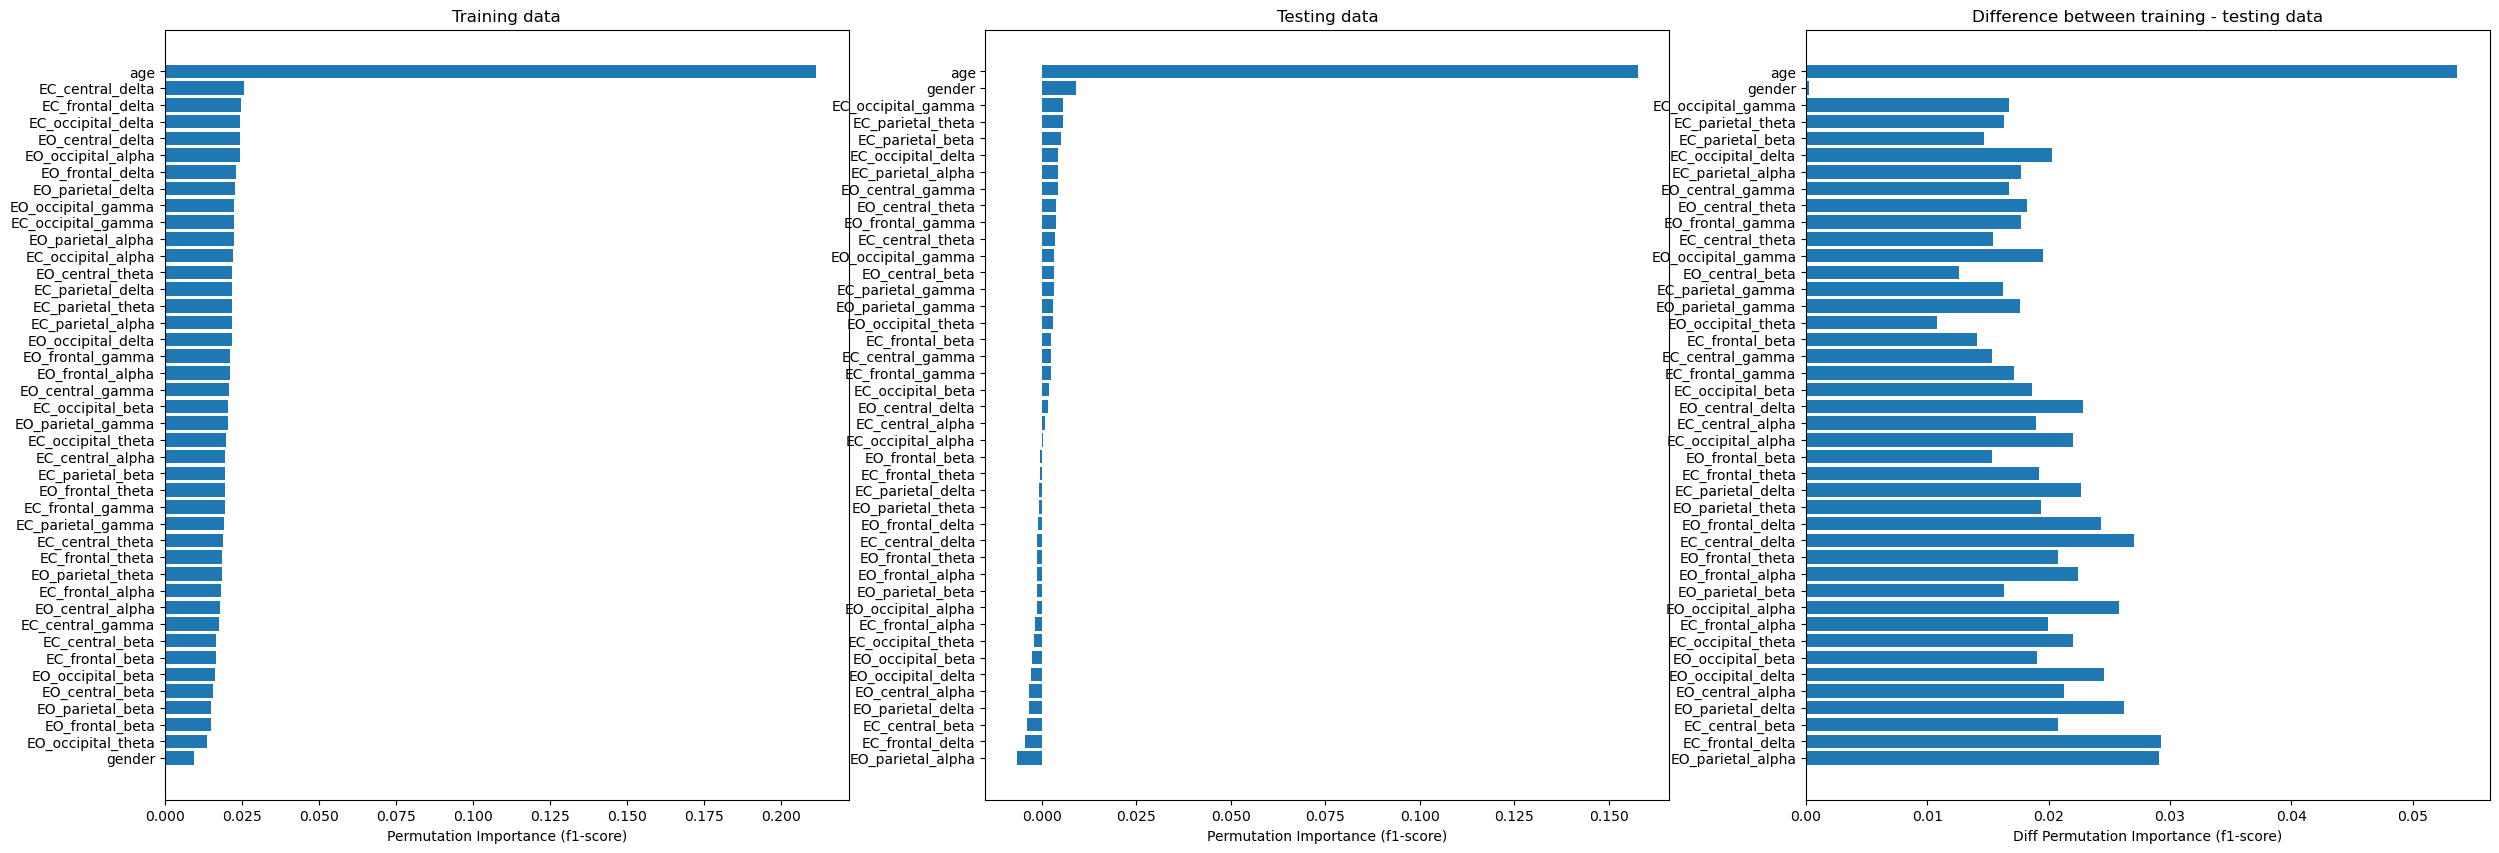

In [61]:
# using permutation_importance(), but according to literature it isn't a very reliable method for SVC with rbf kernel
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y.iloc[train_idxs]
Y_test = Y.iloc[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


f1_score: 0.40430463314116616

classification report:
               precision    recall  f1-score   support

        ADHD       0.43      0.54      0.48      2051
     HEALTHY       0.14      0.14      0.14       564
         MDD       0.54      0.46      0.50      3732
         OCD       0.10      0.09      0.10       540
         SMC       0.22      0.23      0.22      1032

    accuracy                           0.40      7919
   macro avg       0.29      0.29      0.29      7919
weighted avg       0.41      0.40      0.40      7919



[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   18.6s finished


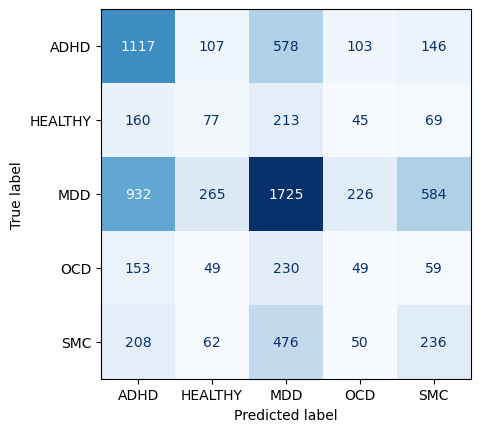

In [62]:
# fitting model without age as feature to see importance
X_no_age = X.drop(columns = ['age'])
numeric_cols.remove('age')

# final pipeline
steps = [('col_trans', col_trans), ('rbf_svm', svm.SVC(kernel = 'rbf', C = 1, gamma = 0.1, class_weight = 'balanced'))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X_no_age, Y,  cv = cv_outer, groups = groups, verbose=2, n_jobs=4)    
class_labels = sorted(top_5)
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted'))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)

### One-vs-Rest classification

In [8]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC


# assign groups (IDs) for GroupKFold
groups = df_features['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = ['age']
for cond in ['EO', 'EC']:
    for band in bands:
        for group in channel_groups:
            numeric_cols.append(f'{cond}_{group}_{band}')
cat_cols = ['gender']
 
X = df_features[numeric_cols + cat_cols]
Y = df_features['diagnosis']

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')) # median imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# hyperparameter ranges for GridSearch
param_grid = {
'ovr_svm__estimator__C': [0.01, 0.1, 1, 10, 100],
'ovr_svm__estimator__gamma': [0.1, 1, 10, 100],
'ovr_svm__estimator__kernel': ['rbf'],
}

# final pipeline
steps = [('col_trans', col_trans), ('ovr_svm', OneVsRestClassifier(SVC(class_weight = 'balanced')))]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

# define gridsearch
gridsearch = GridSearchCV(pipeline,
                        param_grid = param_grid,
                        cv = cv_inner, # use inner cv for hyperparameter tuning
                        scoring = f1_scorer,
                        error_score = 'raise',
                        return_train_score = True,
                        n_jobs=4,
                        verbose=2)

# non-nested CV for obtaining the propable best hyperparameters
gridsearch_fit = gridsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {gridsearch_fit.best_params_}')
print(f'Best f1-score: {gridsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
svm_test_score = cross_val_score(gridsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=2,
                                 n_jobs=4)
print('SVM test scores:', svm_test_score)
print('Mean SVM test score:', np.mean(svm_test_score))


# of instances: 7919
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'ovr_svm__estimator__C': 1, 'ovr_svm__estimator__gamma': 0.1, 'ovr_svm__estimator__kernel': 'rbf'}
Best f1-score: 0.5133186880461887


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM test scores: [0.52350592 0.52108314 0.50726069 0.51729347 0.54796023]
Mean SVM test score: 0.5234206902858267


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 26.8min finished


f1_score: 0.5217804753348769

classification report:
               precision    recall  f1-score   support

        ADHD       0.53      0.65      0.59      2051
     HEALTHY       0.19      0.15      0.17       564
         MDD       0.62      0.58      0.59      3732
         OCD       0.19      0.13      0.16       540
         SMC       0.50      0.53      0.52      1032

    accuracy                           0.53      7919
   macro avg       0.41      0.41      0.40      7919
weighted avg       0.52      0.53      0.52      7919



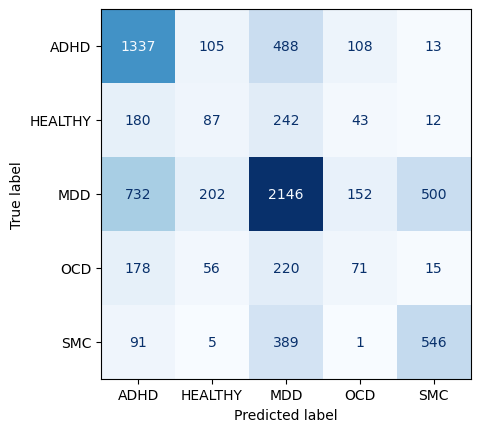

In [9]:
# final pipeline
steps = [('col_trans', col_trans), ('rbf_svm', SVC(kernel = 'rbf', C = 1, gamma = 0.1, class_weight = 'balanced'))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=4)    
class_labels = sorted(top_5)
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted'))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)
